<a href="https://colab.research.google.com/github/alexwangliting/MachineLearning2Submission_WangLiTing/blob/main/1_ConvNeXtBase_FreezeUnfreeze_OnlyLastLayerTrainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio
!pip install --upgrade gradio
!pip install --upgrade tensorflow
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 923.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.9 MB/s et

In [ ]:
!gdown 10HrFogT1PuROJ2XLWn7NKQa-DnSoiLGC

Downloading...
From (original): https://drive.google.com/uc?id=10HrFogT1PuROJ2XLWn7NKQa-DnSoiLGC
From (redirected): https://drive.google.com/uc?id=10HrFogT1PuROJ2XLWn7NKQa-DnSoiLGC&confirm=t&uuid=a8779c81-989e-4a94-8317-58b9d11e8c15
To: /content/oxfpetsdata.zip
100% 1.13G/1.13G [00:26<00:00, 43.3MB/s]


In [ ]:
!unzip /content/oxfpetsdata.zip

In [ ]:
import torch
import json
import os
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, random_split
from torchvision import datasets
from torchvision.transforms.v2 import Resize
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from functools import partial
from torch.utils.data import Dataset
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, ColorJitter
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, ColorJitter
from collections import defaultdict
import torch.optim as optim
from torchvision.models import convnext_base
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
torch.manual_seed(42)

In [ ]:
def get_img(path):
    return read_image(path).to(torch.float32) / 255
def get_num(num):
    return num
class OxfordPets(Dataset):
    def __init__(self, root, target_types) -> None:
        self._data = []
        __file__ = "/content/"
        if root is None:
            root = "/content/oxfpetsdata"
        with open(os.path.join(root, "data.json"), "r") as f:
            for k, v in json.load(f).items():
                targets = {
                    "category": partial(get_num, v["category"]),
                    "species_id": partial(get_num, v["species_id"]),
                }
                self._data.append((
                        partial(get_img, os.path.join(root, "images", f"{k}.png")),
                        *(targets[t] for t in target_types),
                    ))
    def __len__(self):
        return len(self._data)
    def __getitem__(self, idx):
        sample = [func() for func in self._data[idx]]
        return sample

In [ ]:
image_transforms = Compose([
    Resize((128, 128), antialias=True),
    RandomHorizontalFlip(),
    RandomRotation(20),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transform=None, augmentations_per_image=5):
        self.original_dataset = original_dataset
        self.transform = transform
        self.augmentations_per_image = augmentations_per_image
    def __len__(self):
        return len(self.original_dataset) * self.augmentations_per_image
    def __getitem__(self, idx):
        original_idx = idx // self.augmentations_per_image
        original_image, label = self.original_dataset[original_idx]
        if self.transform:
            augmented_image = self.transform(original_image)
            return augmented_image, label
        return original_image, label
data = OxfordPets(root=None, target_types=['category'])
augmented_data = AugmentedDataset(data, transform=image_transforms, augmentations_per_image=5)
train_size = int(0.8 * len(augmented_data))
test_size = len(augmented_data) - train_size
train_dataset, test_dataset = random_split(augmented_data, [train_size, test_size])
train_sampler = RandomSampler(train_dataset)
test_sampler = SequentialSampler(test_dataset)
BATCH_SIZE = 32
data_loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
data_loader_test = DataLoader(test_dataset, batch_size=1, sampler=test_sampler)

In [ ]:
total_train_data_points = len(data_loader_train)
total_test_data_points = len(data_loader_test)
print("Total number of train data points:", total_train_data_points*BATCH_SIZE)
print("Total number of test data points:", total_test_data_points)

Total number of train data points: 14688
Total number of test data points: 3671


Class: 0, Count: 406
Class: 1, Count: 399
Class: 2, Count: 391
Class: 3, Count: 397
Class: 4, Count: 398
Class: 5, Count: 394
Class: 6, Count: 402
Class: 7, Count: 383
Class: 8, Count: 409
Class: 9, Count: 397
Class: 10, Count: 396
Class: 11, Count: 358
Class: 12, Count: 382
Class: 13, Count: 406
Class: 14, Count: 400
Class: 15, Count: 395
Class: 16, Count: 404
Class: 17, Count: 408
Class: 18, Count: 392
Class: 19, Count: 384
Class: 20, Count: 388
Class: 21, Count: 386
Class: 22, Count: 390
Class: 23, Count: 394
Class: 24, Count: 415
Class: 25, Count: 395
Class: 26, Count: 388
Class: 27, Count: 403
Class: 28, Count: 397
Class: 29, Count: 390
Class: 30, Count: 403
Class: 31, Count: 408
Class: 32, Count: 401
Class: 33, Count: 401
Class: 34, Count: 402
Class: 35, Count: 408
Class: 36, Count: 414
Total count of all classes: 14684


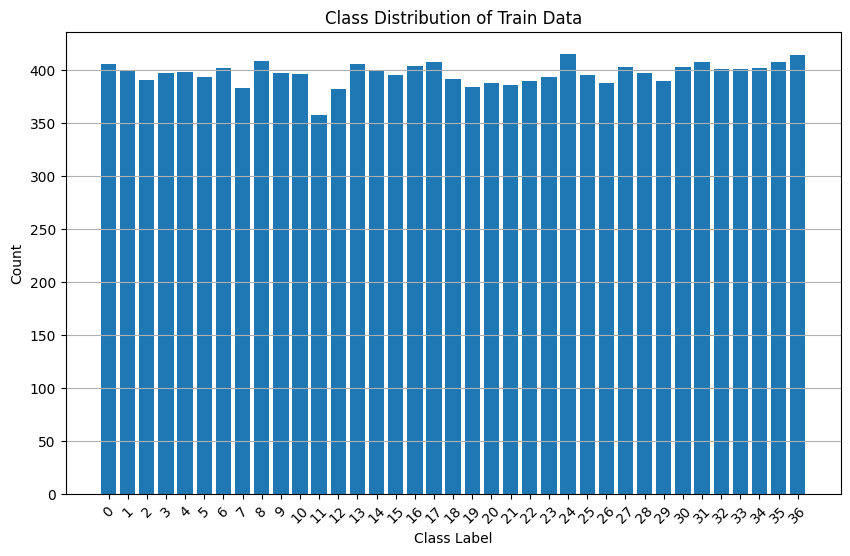

In [ ]:
from collections import defaultdict
def inspect_data(desired_data, name):
    class_counts = defaultdict(int)
    for data in desired_data.dataset:
        class_label = data[1]
        class_counts[class_label] += 1
    sorted_class_counts = sorted(class_counts.items())
    for class_label, count in sorted_class_counts:
        print(f"Class: {class_label}, Count: {count}")
    import matplotlib.pyplot as plt
    class_labels, counts = zip(*sorted_class_counts)
    total_count = sum(class_counts.values())
    print(f"Total count of all classes: {total_count}")
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(class_labels)), counts)
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.title(f'Class Distribution of {name}')
    plt.xticks(range(len(class_labels)), class_labels, rotation=45)
    plt.grid(axis='y')
    plt.show()
inspect_data(data_loader_train, "Train Data")

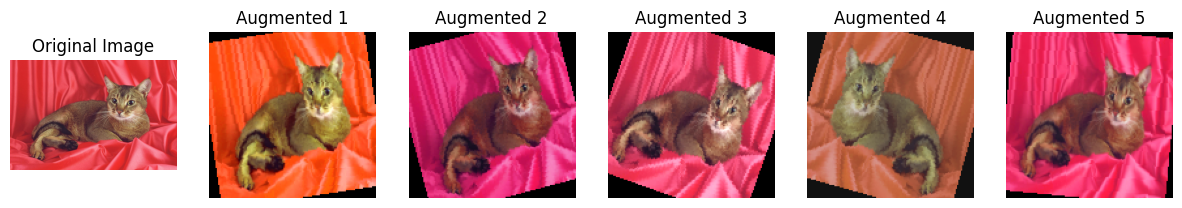

In [ ]:
def show_all_augmented_images(original_dataset, transform, index, augmentations_count=5):
    original_image, _ = original_dataset[index]
    original_image_pil = F.to_pil_image(original_image)
    fig, axs = plt.subplots(1, augmentations_count + 1, figsize=(15, 5))
    axs[0].imshow(original_image_pil)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    for i in range(augmentations_count):
        augmented_image = transform(original_image_pil)
        axs[i + 1].imshow(augmented_image)
        axs[i + 1].set_title(f"Augmented {i+1}")
        axs[i + 1].axis('off')
    plt.show()
index_to_show = 5
show_all_augmented_images(data, image_transforms, index_to_show, augmentations_count=5)

In [ ]:
model = convnext_base(pretrained=True)
num_classes = 37
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[2].parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:02<00:00, 151MB/s]


In [ ]:
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_train += labels.size(0)
    epoch_loss = running_loss / total_train
    epoch_acc = running_corrects.double() / total_train
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
torch.save(model.state_dict(), 'fine_tunned_convnext_model.pth')
print('Model saved successfully!')

Epoch 1/2
Train Loss: 1.5275 Acc: 0.7126
Epoch 2/2
Train Loss: 0.7002 Acc: 0.8249
Model saved successfully!


In [ ]:
model = convnext_base(pretrained=False)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)\
model.load_state_dict(torch.load('fine_tunned_convnext_model.pth'))
model.to(device)
print('Model loaded successfully!')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 85.10%
